In [1]:
import copy
import pandas as pd
import numpy as np
import scipy as sp
import batman
import lightkurve as lk
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

A deep dive investigation into TESS data for WASP 12b, the only planet for which a period change has been confirmed.

#### Identify rough transit times

Analyse lightcurve, get initial estimate of the period and isolated the lightcurve for each transit using a BLS periodogram.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

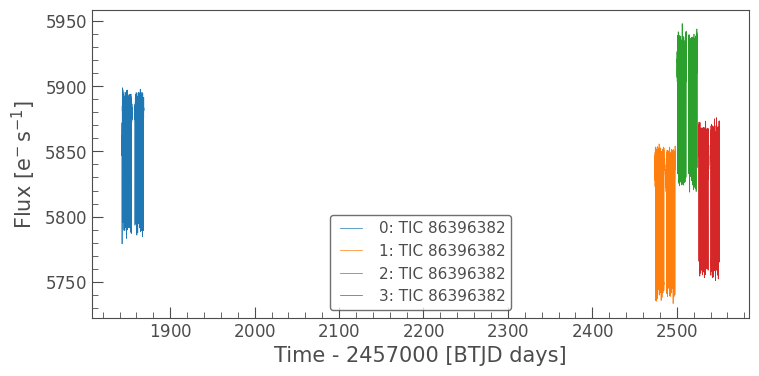

In [2]:
search_result = lk.search_lightcurve("WASP-12b", author="TESS-SPOC")
lc_collection = search_result.download_all()
lc_collection.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

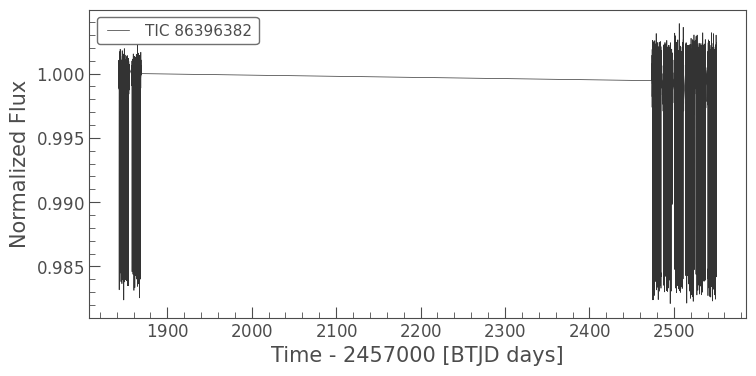

In [3]:
lc = lc_collection.stitch().flatten(window_length=5001).remove_outliers()
lc.plot()

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

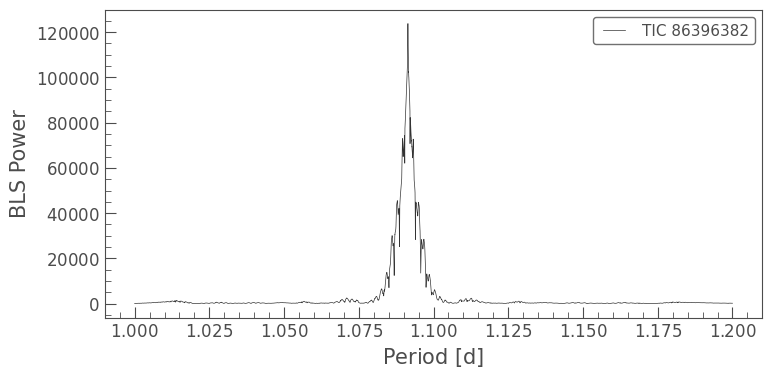

In [4]:
period = np.linspace(1, 1.2, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

In [5]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_period

<Quantity 1.09142914 d>

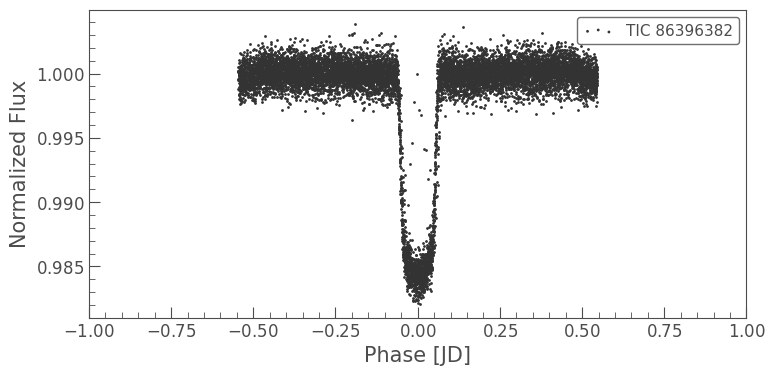

In [6]:
folded_lc = lc.fold(period=planet_b_period, epoch_time=planet_b_t0)
ax = folded_lc.scatter()
ax.set_xlim(-1, 1);

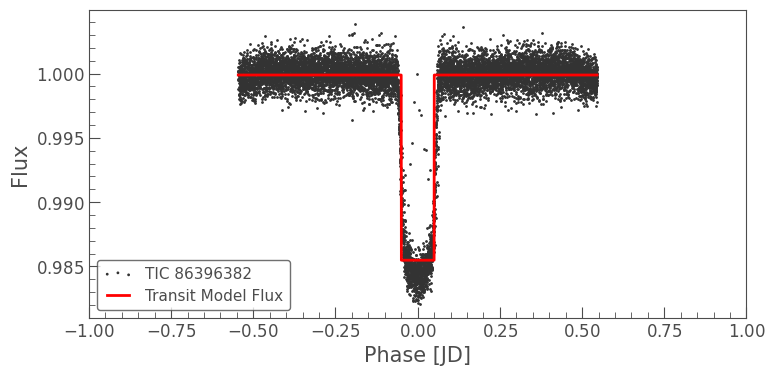

In [7]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

ax = folded_lc.scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

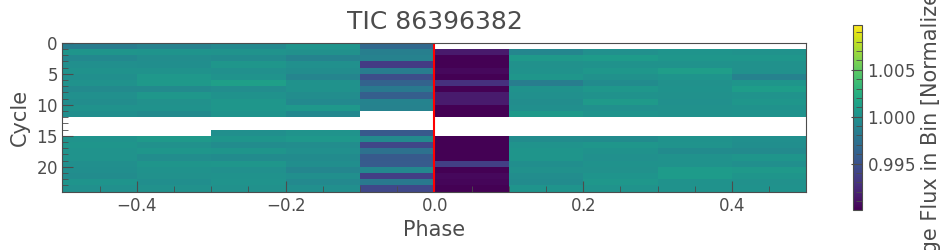

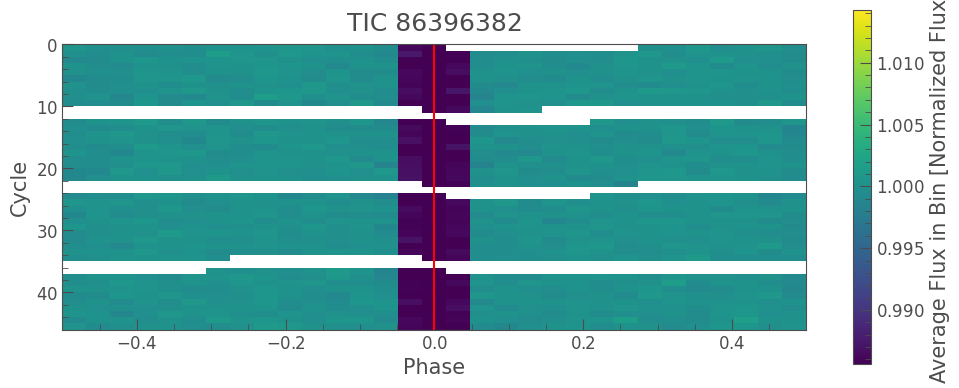

In [8]:
ax = lc_collection[0].flatten().fold(planet_b_period, planet_b_t0).plot_river(bin_points=5, method="median")
plt.axvline(x=0, c="r")

ax = lc_collection[1:3].stitch().flatten().fold(planet_b_period, planet_b_t0).plot_river(bin_points=5, method="median")
plt.axvline(x=0, c="r")

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


Text(0.5, 0, 'time')

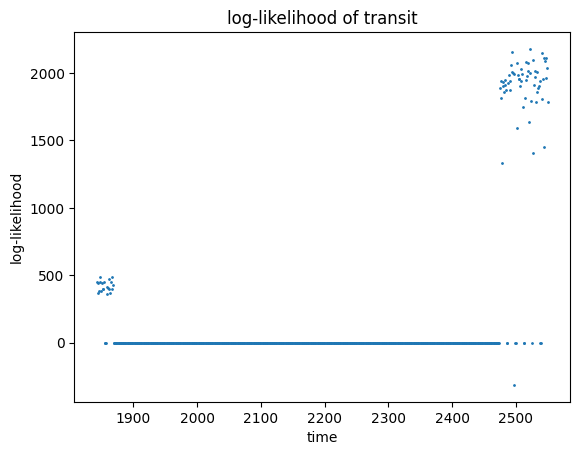

In [9]:
bls_stats = bls.compute_stats()
plt.scatter(x=[tt.value for tt in bls_stats.get("transit_times")], y=bls_stats.get("per_transit_log_likelihood"), s=1)
plt.title("log-likelihood of transit")
plt.ylabel("log-likelihood")
plt.xlabel("time")

In [10]:
bls_transit_times = bls_stats.get("transit_times")
split_light_curves = []
for transit_time in tqdm(bls_transit_times):
    try:
        split_lc = lc.loc[transit_time-planet_b_period/2:transit_time+planet_b_period/2]
    except KeyError:
        pass
    else:
        split_light_curves.append(split_lc)

100%|████████████████████████████████████████████████████| 649/649 [00:02<00:00, 240.44it/s]


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

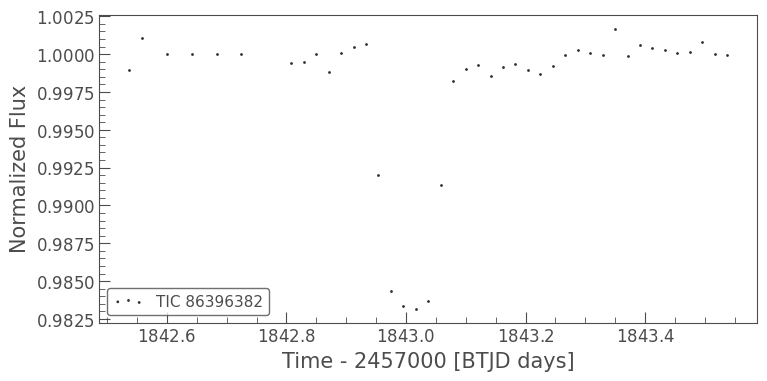

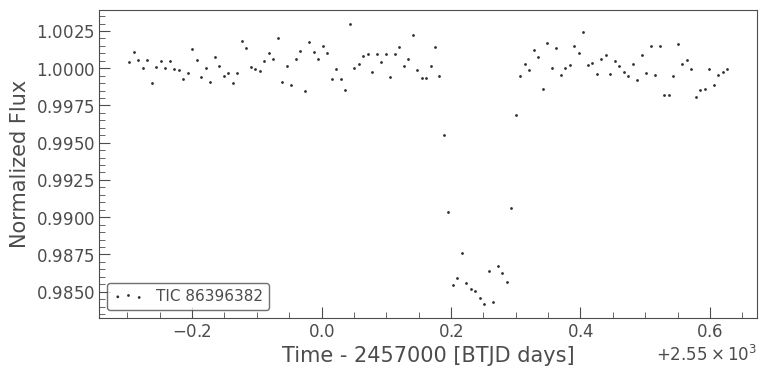

In [11]:
split_light_curves[0].scatter()
split_light_curves[-1].scatter()

#### Fit each transit by maximum likelihood estimation

I had an initial go here and doing a BLS fit per transit as a simple way of getting the transit time, but this didn't work very well, so instead we fit a full transit model to each transit.

We assumed that the uncertainty on the measured flux is independent of time such that data point is normally distributed with mean = the model's prediction and standard deviation = an unknown parameter sd.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

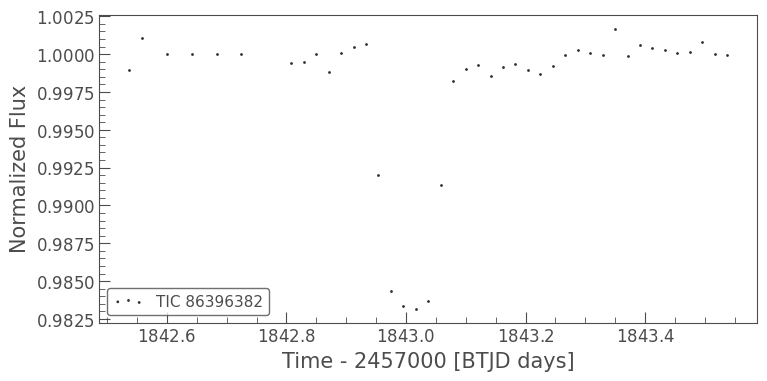

In [12]:
# model the first light curve
test_lc = split_light_curves[0]
actual_flux = test_lc.flux.value
test_lc.scatter()

In [13]:
# create the transit model with sensible initial values
params = batman.TransitParams()
params.t0 = np.median(test_lc.time.value)                   # time of inferior conjunction (days for consistency)
params.per = 1.0912091               # orbital period (days - can be anything in the model so long as it is consistent)
params.rp = 0.1                      # planet radius (in units of stellar radii)
params.a = 5.                        # semi-major axis (in units of stellar radii)
params.inc = 84.                     # orbital inclination (in degrees)
params.ecc = 0.                      # eccentricity
params.w = 90.                       # longitude of periastron (in degrees)
params.u = [0.2131, 0.3212]          # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       # limb darkening model

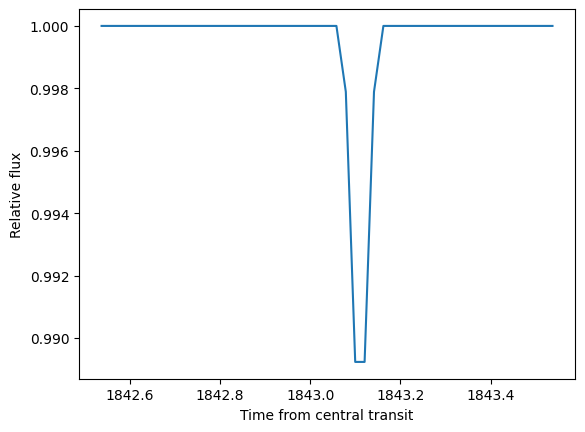

In [14]:
t = test_lc.time.value
m = batman.TransitModel(params, t)    # initializes model
flux = m.light_curve(params)          # calculates light curve

plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

In [15]:
def neg_log_likelihood(x):
    sd, t0, per, rp, a, inc, w = x

    params.t0 = t0
    params.per = per
    params.rp = rp
    params.a = a
    params.inc = inc
    params.w = w

    N = len(actual_flux)
    model_flux = m.light_curve(params)
    neg_log_likelihood = (N/2 * np.log(2*sp.constants.pi*(sd**2))) + (0.5 * np.sum(((actual_flux-model_flux)/sd)**2))
    
    return neg_log_likelihood

In [16]:
res = sp.optimize.minimize(neg_log_likelihood, (0.1, params.t0, params.per, params.rp, params.a, params.inc, params.w), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
res.message

Optimization terminated successfully.
         Current function value: -246.933722
         Iterations: 2652
         Function evaluations: 4097


'Optimization terminated successfully.'

In [17]:
vars(params)

{'t0': 3210.5091605940725,
 'per': 1.7993439977894083,
 'rp': 0.13291470278586376,
 'a': 3.103015694695673,
 'inc': 74.82334830757355,
 'ecc': 0.0,
 'w': 138.72823830077803,
 'u': [0.2131, 0.3212],
 'limb_dark': 'quadratic',
 'fp': None,
 't_secondary': None}

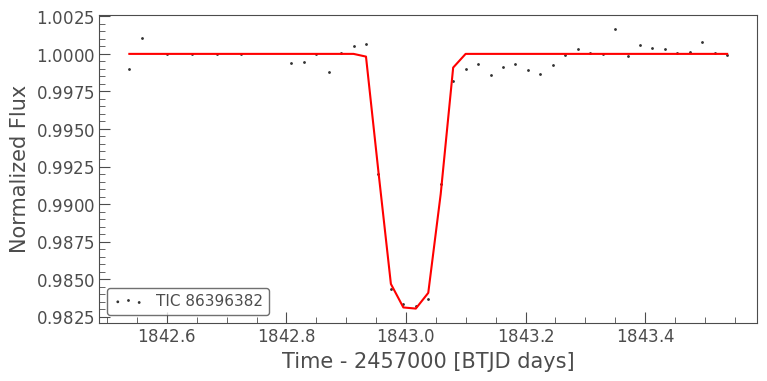

In [18]:
test_lc.scatter()
flux = m.light_curve(params)
plt.plot(test_lc.time.value, flux, c="r")

In [19]:
sp.constants.au / 6.95700e8

215.03215567054764

In [20]:
# let's do this for all the light curves and collect the fitted periods
model_params = []

for split_lc in tqdm(split_light_curves):
    # create the transit model with sensible initial values
    t = split_lc.time.value  # times at which flux was measured
    actual_flux = split_lc.flux.value

    params = batman.TransitParams()
    params.t0 = np.median(t)             # time of inferior conjunction (days for consistency)
    params.per = 1.1                     # orbital period (days - can be anything in the model so long as it is consistent)
    params.rp = 0.1166445                # planet radius (in units of stellar radii)
    params.a = 5.                        # semi-major axis (in units of stellar radii)
    params.inc = 87.                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = [0.2131, 0.3212]          # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model

    m = batman.TransitModel(params, t)    # initializes model

    def neg_log_likelihood(x):
        sd, t0, per, rp, a, inc, w = x

        params.t0 = t0
        params.per = per
        params.rp = rp
        params.a = a
        params.inc = inc
        params.w = w

        N = len(actual_flux)
        model_flux = m.light_curve(params)
        neg_log_likelihood = (N/2 * np.log(2*sp.constants.pi*(sd**2))) + (0.5 * np.sum(((actual_flux-model_flux)/sd)**2))

        return neg_log_likelihood
    
    res = sp.optimize.minimize(neg_log_likelihood, (0.1, params.t0, params.per, params.rp, params.a, params.inc, params.w), method="Nelder-Mead", options={'disp': False, "maxiter": 1e4})
    model_params.append(copy.deepcopy(params))

100%|███████████████████████████████████████████████████████| 89/89 [00:04<00:00, 21.04it/s]


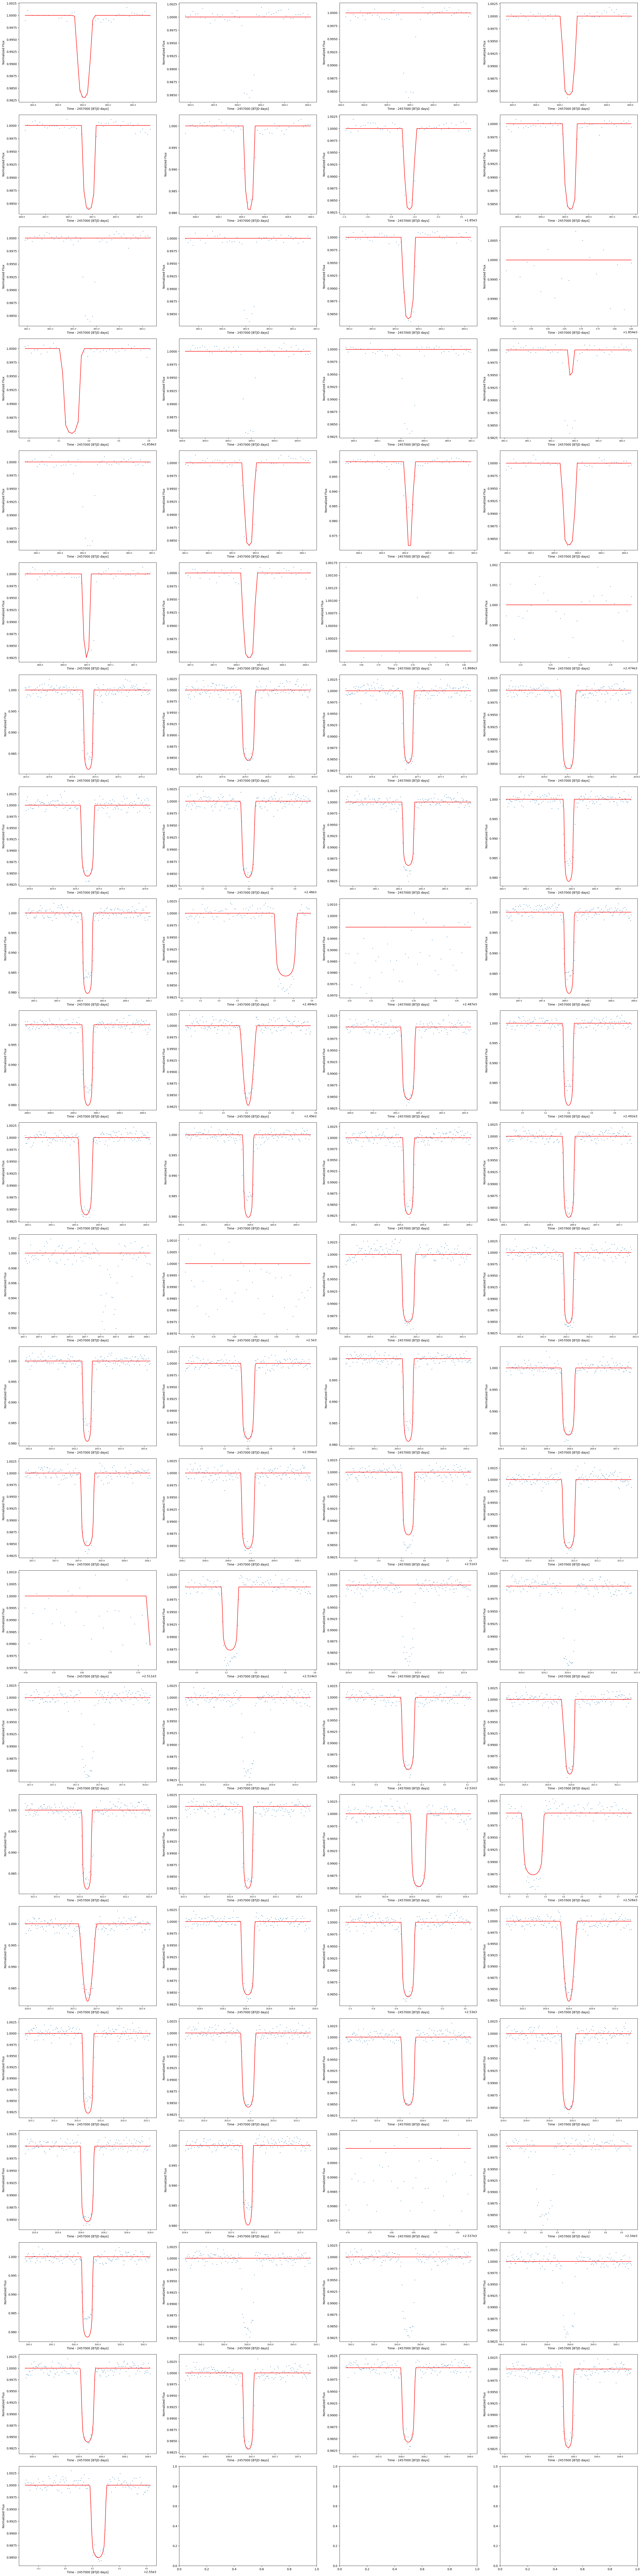

In [21]:
fig, axs = plt.subplots((len(model_params) // 4) + 1, 4, figsize=(30, 120))

for i, p in enumerate(model_params):
    ax = axs.flat[i]
    
    split_lc = split_light_curves[i]
    p = model_params[i]
    m = batman.TransitModel(p, split_lc.time.value)
    model_flux = m.light_curve(p)
    split_lc.scatter(ax=ax)
    ax.plot(split_lc.time.value, model_flux, c="r")
    ax.get_legend().remove()
    ax.tick_params(axis="x", labelsize=6)

fig.tight_layout()
plt.show()

In [45]:
i = 0
lc1 = split_light_curves[i]
p1 = model_params[i]
# timings = np.linspace(min(lc1.time.value), max(lc1.time.value), 200)
m1 = batman.TransitModel(p1, lc1.time.value)
model_flux1 = m1.light_curve(p1)
# lc1.scatter()
# plt.show()

i = -2
lc2 = split_light_curves[i]
p2 = model_params[i]
m2 = batman.TransitModel(p2, lc2.time.value)
model_flux2 = m2.light_curve(p2)
# lc2.scatter()
# plt.show()

period = 1.0912091
t01 = 1843.01
t02 = 2549.151
orbital_diff = (t02 - t01) % period

relative1 = lc1.time.value - t01
relative2 = lc2.time.value - t02 # (whole_num_orbits_diff*period) - t01

relative1, relative2

plt.rc('axes', titlesize=32)     # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=32)    # fontsize of the tick labels
plt.rc('ytick', labelsize=32)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rcParams['figure.dpi'] = 600

plt.figure(figsize=(20,10))
# plt.scatter(relative1, lc1.flux.value)
# plt.plot(relative1, model_flux1, label=f"Observations commencing {lc1.time.strftime('%d %b %Y')[0]}")

plt.scatter(relative2, lc2.flux.value)
plt.plot(relative2, model_flux2, label=f"Observations commencing {lc2.time.strftime('%d %b %Y')[0]}")
plt.plot(relative2-0.01, model_flux2, label=f"Predicted observations in ~10 years time")

plt.xlim(-0.3, 0.3)
plt.legend()
plt.xlabel("Period-folded BJD")
plt.ylabel("Normalized light flux")
plt.show()

orbital_diff
# plot(x, y, color='green', marker='o', linestyle='dashed',
#      linewidth=2, markersize=12)

0.1287122999998931

In [23]:
-9.45e-10 * 24 * 60 * 60 * 1000

-0.081648

In [24]:
E = (0.01 / (0.5*(9.45e-10)))**0.5
E*period

5020.038786339779

In [25]:
5020.038786339779 / 365.25

13.744117142614042

<Axes: xlabel='times', ylabel='inc'>

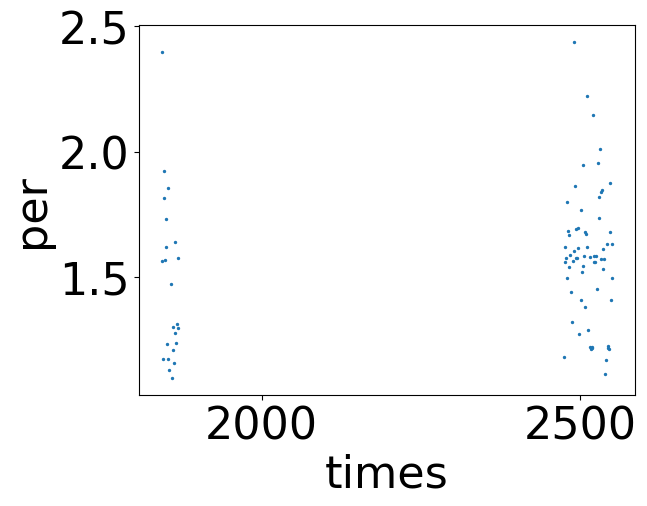

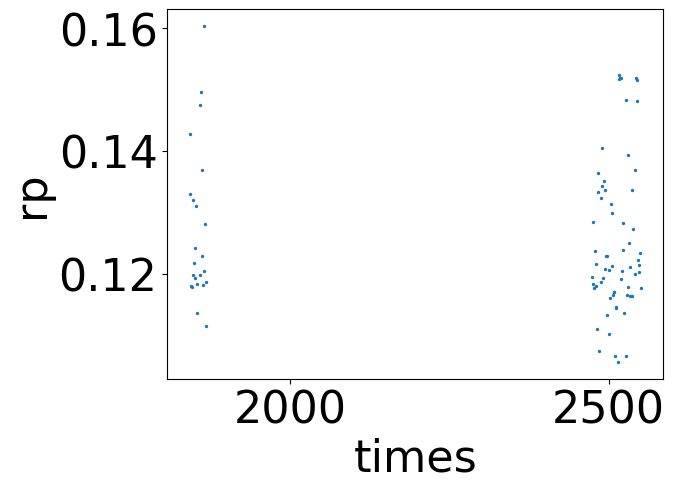

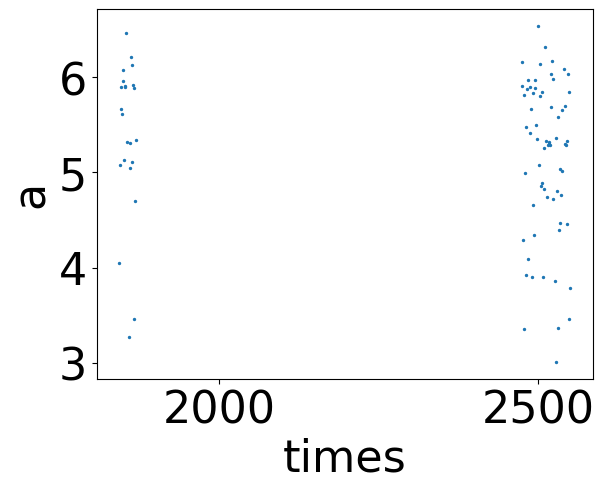

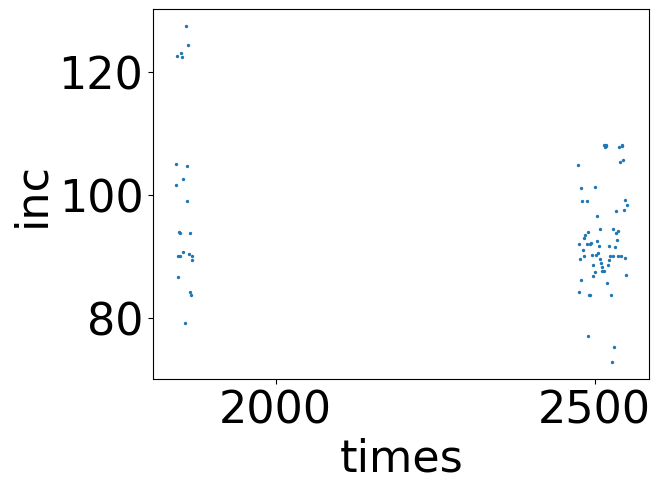

In [26]:
times = [np.median(split_lc.time.value) for split_lc in split_light_curves]
df = pd.DataFrame.from_dict([vars(p) for p in model_params])
df["times"] = times
df.plot.scatter(x="times", y="per", s=2)
df.plot.scatter(x="times", y="rp", s=2)
df.plot.scatter(x="times", y="a", s=2)
df.plot.scatter(x="times", y="inc", s=2)

#### Fit all the parameters that don't change

I'm struggling to fit the individual transits with the same parameters. I'm finding that whilst the fitted curves look pretty good, the model will change parameters that are not expected to change, like the radius and inclination rather than the period. So let's start by fixing all the parameters that are assumed to be independent of time.

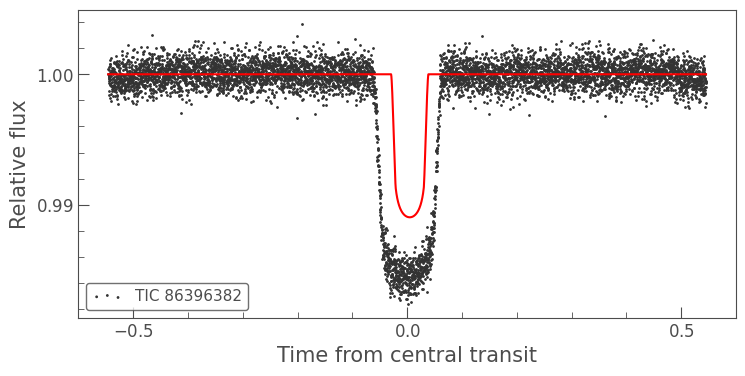

In [27]:
folded_lc = lc_collection[1:3].stitch().flatten().fold(planet_b_period, planet_b_t0)
actual_flux = folded_lc.flux.value

# create the transit model with sensible initial values
params = batman.TransitParams()
params.t0 = np.median(folded_lc.time.value)                   # time of inferior conjunction (days for consistency)
params.per = 1.0912091               # orbital period (days - can be anything in the model so long as it is consistent)
params.rp = 0.1                      # planet radius (in units of stellar radii)
params.a = 5.                        # semi-major axis (in units of stellar radii)
params.inc = 84.                     # orbital inclination (in degrees)
params.ecc = 0.                      # eccentricity
params.w = 90.                       # longitude of periastron (in degrees)
params.u = [0.2131, 0.3212]          # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       # limb darkening model

t = folded_lc.time.value
m = batman.TransitModel(params, t)    # initializes model
flux = m.light_curve(params)          # calculates light curve

folded_lc.scatter()
plt.plot(t, flux, c="r")
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

In [28]:
def neg_log_likelihood(x):
    sd, t0, rp, a, inc, w = x

    params.t0 = t0
    params.rp = rp
    params.a = a
    params.inc = inc
    params.w = w

    N = len(actual_flux)
    model_flux = m.light_curve(params)
    neg_log_likelihood = (N/2 * np.log(2*sp.constants.pi*(sd**2))) + (0.5 * np.nansum(((actual_flux-model_flux)/sd)**2))
    return neg_log_likelihood

res = sp.optimize.minimize(neg_log_likelihood, (0.01, params.t0, params.rp, params.a, params.inc, params.w), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})
res.message

Optimization terminated successfully.
         Current function value: -37606.972073
         Iterations: 522
         Function evaluations: 848


'Optimization terminated successfully.'

In [29]:
vars(params)

{'t0': 0.0002707601803780183,
 'per': 1.0912091,
 'rp': 0.11824937832944335,
 'a': 2.9272414484433478,
 'inc': 98.78402026788943,
 'ecc': 0.0,
 'w': 270.6007639908024,
 'u': [0.2131, 0.3212],
 'limb_dark': 'quadratic',
 'fp': None,
 't_secondary': None}

Roughly similar to the values found in Turner et al 2020

In [30]:
folded_params = copy.deepcopy(params)

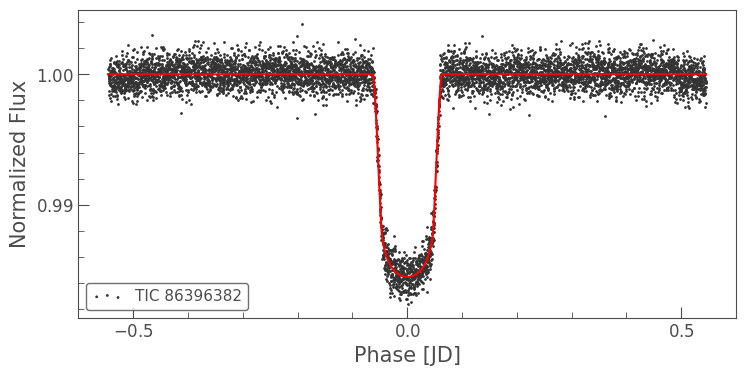

In [31]:
folded_lc.scatter()
flux = m.light_curve(folded_params)
plt.plot(folded_lc.time.value, flux, c="r")

#### Fit all the parameters that do change

In [32]:
# let's do this for all the light curves and collect the fitted periods
model_params_constrained = []

for split_lc in tqdm(split_light_curves):
    # create the transit model with sensible initial values
    t = split_lc.time.value  # times at which flux was measured
    actual_flux = split_lc.flux.value

    params = batman.TransitParams()
    params.t0 = np.median(t)             # time of inferior conjunction (days for consistency)
    params.per = folded_params.per                     # orbital period (days - can be anything in the model so long as it is consistent)
    params.rp = folded_params.rp                # planet radius (in units of stellar radii)
    params.a = folded_params.a                      # semi-major axis (in units of stellar radii)
    params.inc = folded_params.inc                     # orbital inclination (in degrees)
    params.ecc = folded_params.ecc                      # eccentricity
    params.w = folded_params.w                       # longitude of periastron (in degrees)
    params.u = folded_params.u         # limb darkening coefficients [u1, u2]
    params.limb_dark = folded_params.limb_dark       # limb darkening model

    m = batman.TransitModel(params, t)    # initializes model

    def neg_log_likelihood(x):
        sd, t0, per, a = x

        params.t0 = t0
        params.per = per
        params.a = a

        N = len(actual_flux)
        model_flux = m.light_curve(params)
        neg_log_likelihood = (N/2 * np.log(2*sp.constants.pi*(sd**2))) + (0.5 * np.sum(((actual_flux-model_flux)/sd)**2))

        return neg_log_likelihood
    
    res = sp.optimize.minimize(neg_log_likelihood, (0.1, params.t0, params.per, params.a), method="Nelder-Mead", options={'disp': False, "maxiter": 1e4})
    model_params_constrained.append(copy.deepcopy(params))

100%|███████████████████████████████████████████████████████| 89/89 [00:01<00:00, 47.44it/s]


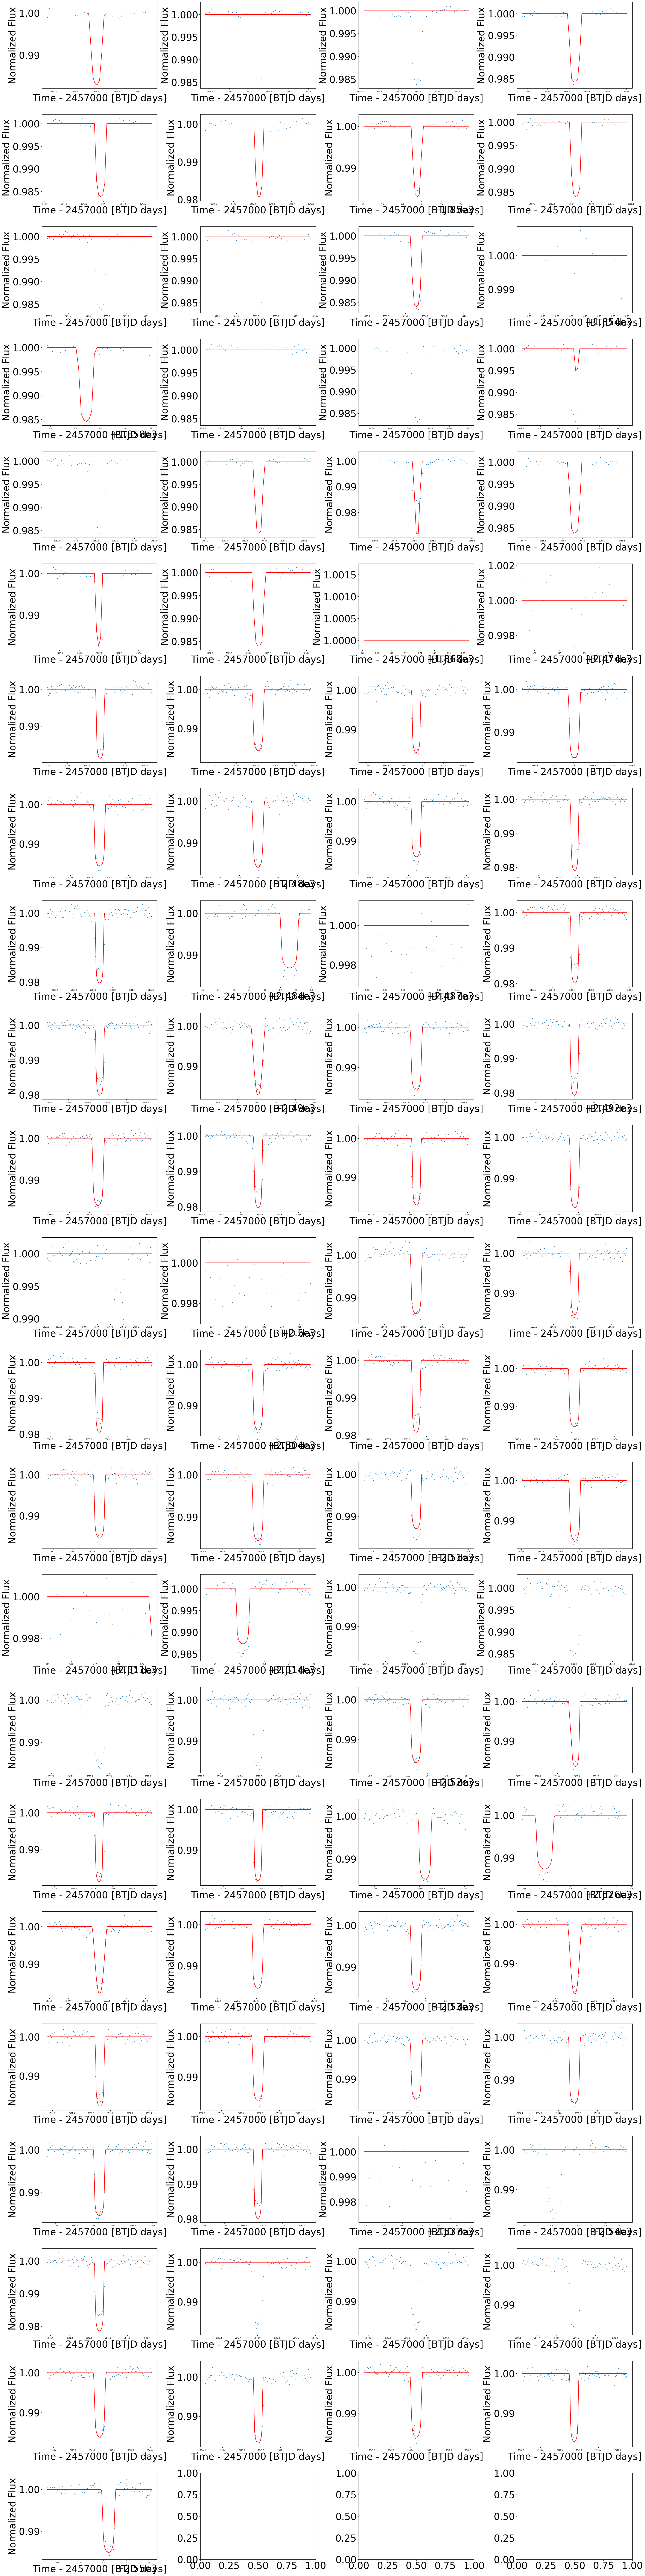

In [33]:
fig, axs = plt.subplots((len(model_params_constrained) // 4) + 1, 4, figsize=(30, 120))

for i, p in enumerate(model_params_constrained):
    ax = axs.flat[i]
    
    split_lc = split_light_curves[i]
    p = model_params[i]
    m = batman.TransitModel(p, split_lc.time.value)
    model_flux = m.light_curve(p)
    split_lc.scatter(ax=ax)
    ax.plot(split_lc.time.value, model_flux, c="r")
    ax.get_legend().remove()
    ax.tick_params(axis="x", labelsize=6)

fig.tight_layout()
plt.show()

<Axes: xlabel='times', ylabel='inc'>

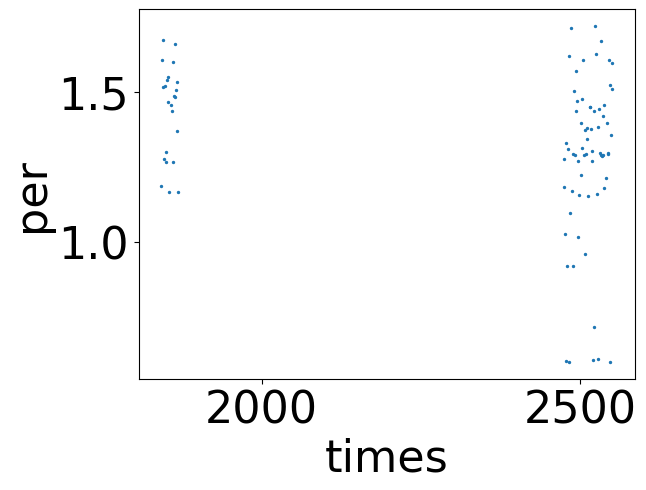

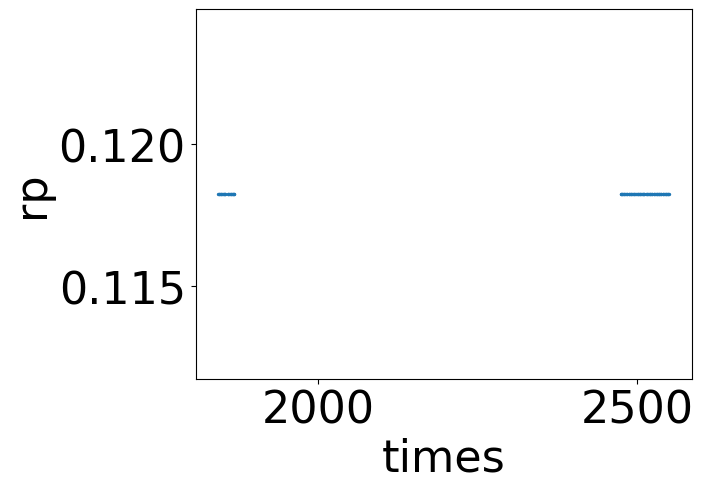

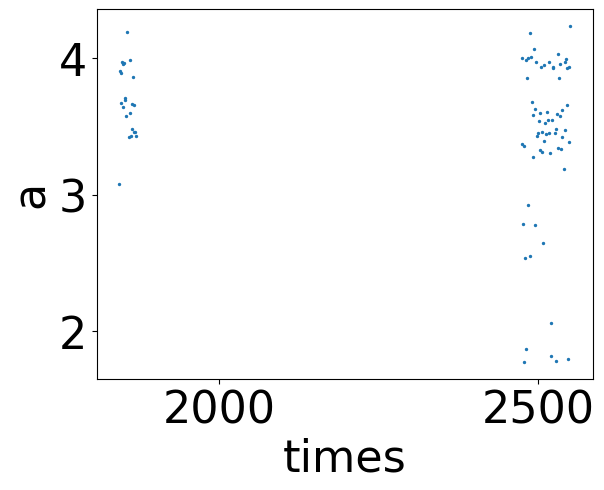

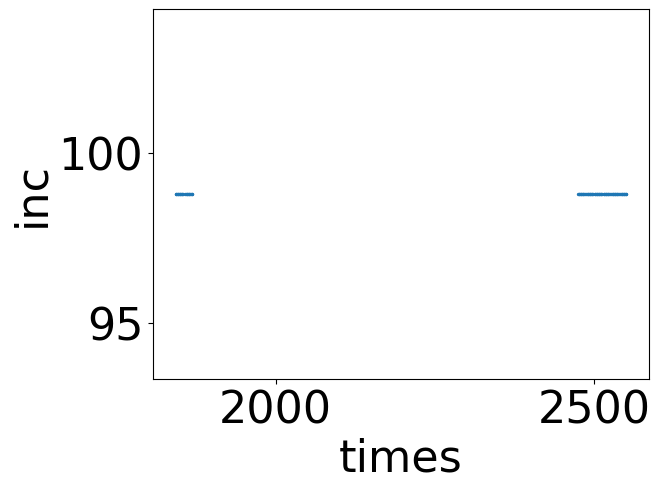

In [34]:
times = [np.median(split_lc.time.value) for split_lc in split_light_curves]
df = pd.DataFrame.from_dict([vars(p) for p in model_params_constrained])
df["times"] = times
df.plot.scatter(x="times", y="per", s=2)
df.plot.scatter(x="times", y="rp", s=2)
df.plot.scatter(x="times", y="a", s=2)
df.plot.scatter(x="times", y="inc", s=2)

The t0 times I get from the model are not very helpful - presumably the model fits to any of the conjunction times rather than the one closest to the transit.

Conclusions: modelling individual transits without constraining the parameters in some way is a bit tricky. It is maybe preferable to construct one big model that incorporates our understanding of orbital decay.

#### Derive t0 from minimum of modelled flux

For each model light curve, extract the time at minimum flux

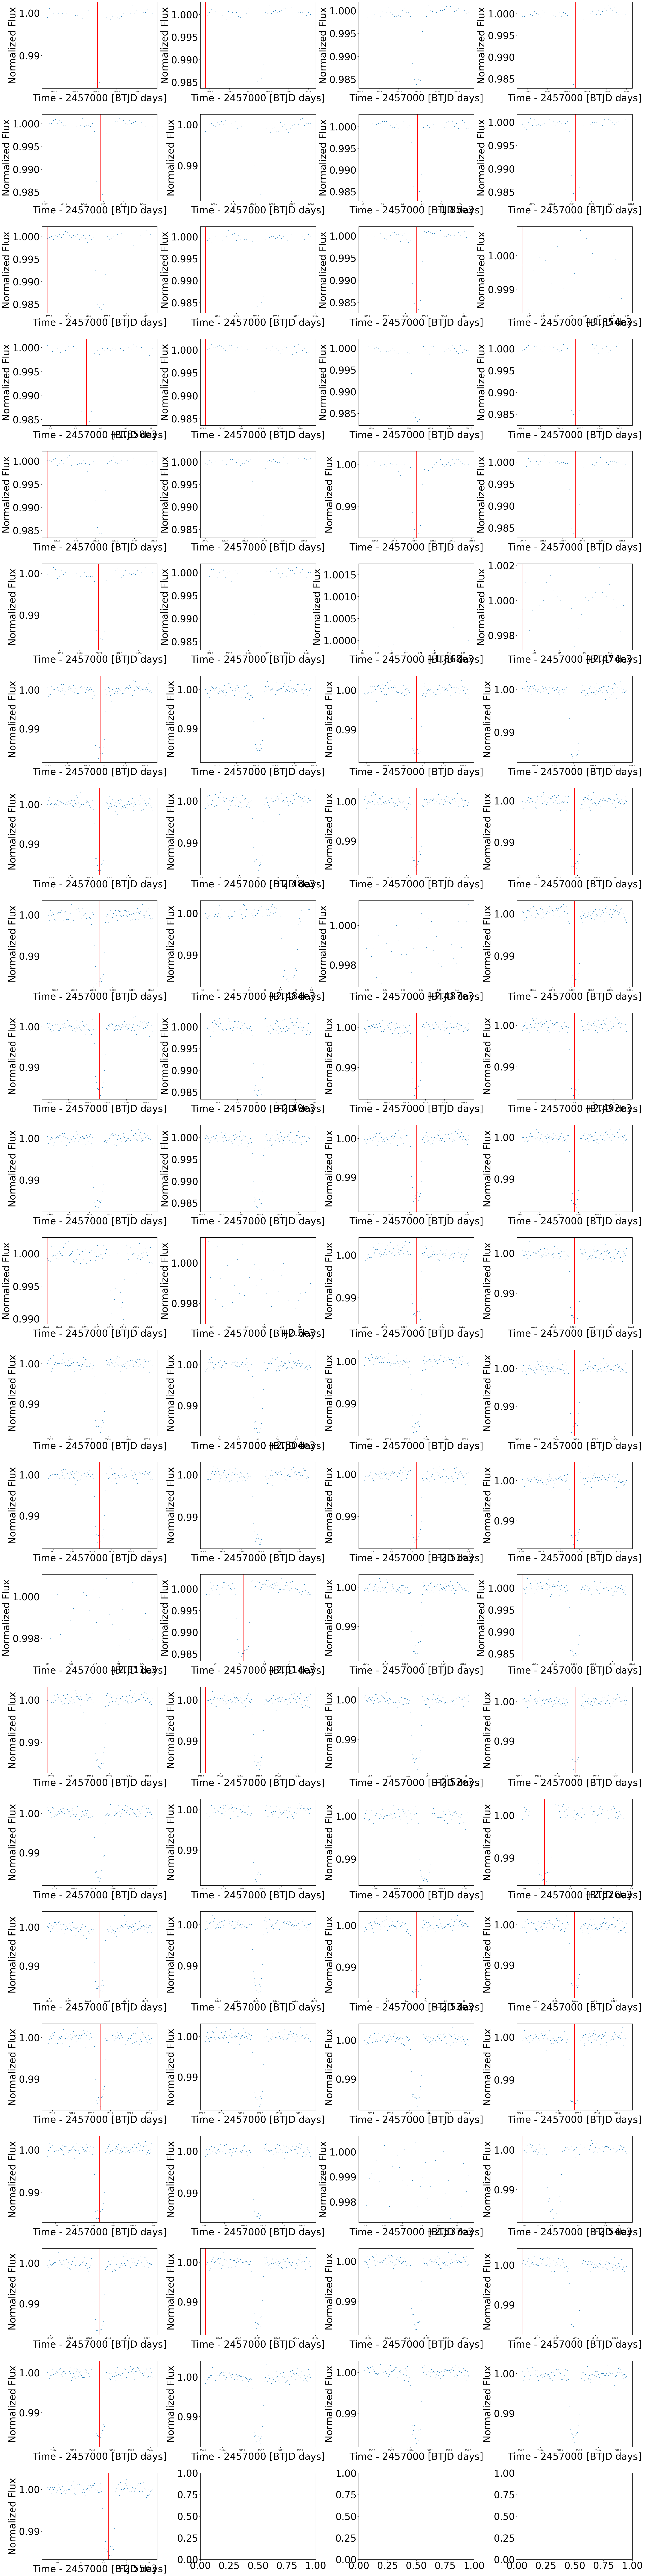

In [35]:
transit_times = []
fig, axs = plt.subplots((len(model_params_constrained) // 4) + 1, 4, figsize=(30, 120))

for i, p in enumerate(model_params_constrained):
    ax = axs.flat[i]

    split_lc = split_light_curves[i]
    p = model_params[i]
    m = batman.TransitModel(p, split_lc.time.value)
    model_flux = m.light_curve(p)
    min_index = np.argmin(model_flux)
    min_time = split_lc.time.value[min_index]
    transit_times.append(min_time)
    
    split_lc.scatter(ax=ax)
    ax.axvline(x=min_time, c="r")
    ax.get_legend().remove()
    ax.tick_params(axis="x", labelsize=6)
    
fig.tight_layout()
plt.show()

In [36]:
transit_times

[1843.0164603381668,
 1843.558132095125,
 1844.6414728346372,
 1846.2873112778263,
 1847.3706442873622,
 1848.4748077460924,
 1849.558135152793,
 1850.641459810696,
 1851.1831210986616,
 1852.2872746057458,
 1853.9122496043829,
 1854.4747392768013,
 1858.2871784733768,
 1858.8288348127594,
 1859.932978099508,
 1861.5579383483187,
 1862.099590403615,
 1863.7453752594304,
 1864.8286733411032,
 1865.9328013131767,
 1866.9952613595667,
 1868.0993835253057,
 1868.6618596558205,
 2474.1759086666675,
 2474.939873254223,
 2476.023314945223,
 2477.120646472781,
 2478.224922548306,
 2479.301417531568,
 2480.391802190506,
 2481.4821862068957,
 2482.572569473868,
 2483.6629518132495,
 2484.760278029128,
 2487.191062478948,
 2488.031425592011,
 2489.1218145358566,
 2490.2122026435413,
 2491.3095349214823,
 2492.3999210732286,
 2493.4903062097815,
 2494.580690259663,
 2495.6710730986556,
 2496.761454520183,
 2497.3101171441294,
 2500.282608438808,
 2501.129914867132,
 2502.2203004019957,
 2503.30373

In [37]:
# let's do this for all the light curves and collect the fitted periods
model_params_constrained = []

for split_lc in tqdm(split_light_curves):
    # create the transit model with sensible initial values
    t = split_lc.time.value  # times at which flux was measured
    actual_flux = split_lc.flux.value

    params = batman.TransitParams()
    params.t0 = np.median(t)             # time of inferior conjunction (days for consistency)
    params.per = folded_params.per                     # orbital period (days - can be anything in the model so long as it is consistent)
    params.rp = folded_params.rp                # planet radius (in units of stellar radii)
    params.a = folded_params.a                      # semi-major axis (in units of stellar radii)
    params.inc = folded_params.inc                     # orbital inclination (in degrees)
    params.ecc = folded_params.ecc                      # eccentricity
    params.w = folded_params.w                       # longitude of periastron (in degrees)
    params.u = folded_params.u         # limb darkening coefficients [u1, u2]
    params.limb_dark = folded_params.limb_dark       # limb darkening model

    m = batman.TransitModel(params, t)    # initializes model

    def neg_log_likelihood(x):
        sd, t0 = x

        params.t0 = t0

        N = len(actual_flux)
        model_flux = m.light_curve(params)
        neg_log_likelihood = (N/2 * np.log(2*sp.constants.pi*(sd**2))) + (0.5 * np.sum(((actual_flux-model_flux)/sd)**2))

        return neg_log_likelihood
    
    res = sp.optimize.minimize(neg_log_likelihood, (0.1, params.t0), method="Nelder-Mead", options={'disp': False, "maxiter": 1e4})
    model_params_constrained.append(copy.deepcopy(params))

100%|██████████████████████████████████████████████████████| 89/89 [00:00<00:00, 136.82it/s]


<Axes: xlabel='times', ylabel='inc'>

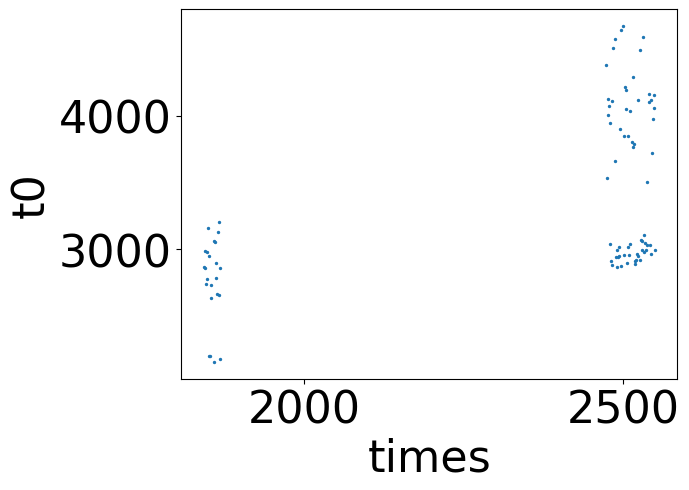

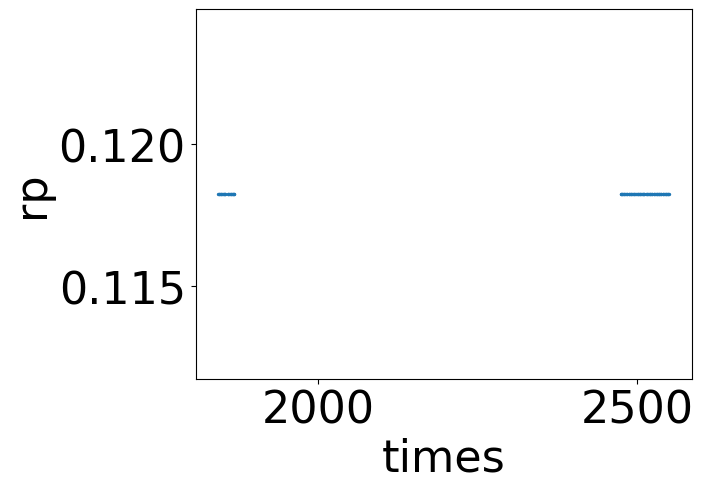

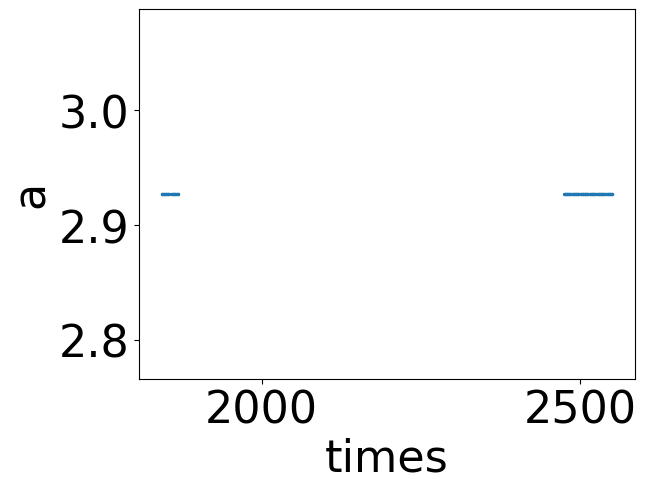

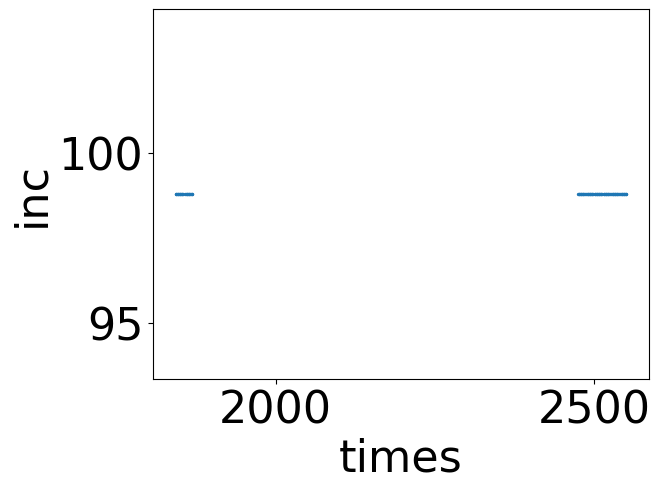

In [38]:
times = [np.median(split_lc.time.value) for split_lc in split_light_curves]
df = pd.DataFrame.from_dict([vars(p) for p in model_params_constrained])
df["times"] = times
df.plot.scatter(x="times", y="t0", s=2)
df.plot.scatter(x="times", y="rp", s=2)
df.plot.scatter(x="times", y="a", s=2)
df.plot.scatter(x="times", y="inc", s=2)

#### Alternative: use a BLS with a p-dot term to find transit times?

This process is a bit fiddly - first we need to find approximate transit times, and then fit a curve to each transit. Maybe we can use a simpler model to determine transit times when the planet has a changing period. Ordinary BLS won't work because it assumes a fixed period.

According to ordinary BLS:

The likelihood of the observed flux given in-transit is: 
$y_\mathrm{in} = \frac{\sum_\mathrm{in} y_n/{\sigma_n}^2}{\sum_\mathrm{in} 1/{\sigma_n}^2}$

The likelihood of the observed flux given out-of-transit is: 
$y_\mathrm{out} = \frac{\sum_\mathrm{out} y_n/{\sigma_n}^2}{\sum_\mathrm{out} 1/{\sigma_n}^2}$

We usually sum these likelihoods over a grid of periods and conjunction times to get a spectrum of the most likely models.

Instead, let's encode t0, the period per, and the change in period pdot... WIP

#### Analysing the change in transit times

Using recorded transit times assembled by Turner et al. let's fit different models to the transit times. Again assume observed deviations in transit times are independent and normally distributed with zero mean and standard deviation sd.

In [39]:
df = pd.read_csv("./data/Papers/turner_2020.csv")
df = df[df["type"] == "tra"]
df = df.set_index("epoch")
df

type  transit_time    error     source
epoch                                       
-1640  tra  2.454516e+06  0.00043        H09
-1346  tra  2.454836e+06  0.00028        C13
-1342  tra  2.454841e+06  0.00062       Ch11
-1067  tra  2.455141e+06  0.00042        C17
-1061  tra  2.455147e+06  0.00043        M13
...    ...           ...      ...        ...
 2344  tra  2.458864e+06  0.00060  ThisPaper
 2345  tra  2.458865e+06  0.00044  ThisPaper
 2346  tra  2.458866e+06  0.00050  ThisPaper
 2347  tra  2.458867e+06  0.00051  ThisPaper
 2348  tra  2.458868e+06  0.00046  ThisPaper

[160 rows x 4 columns]

##### Constant period model

$P(E) = P$

$t_{tra}(E)=T_{ref}+P*E$

In [40]:
Tref = df.at[0, "time"]
P = 1.09
sd = 1.0

KeyError: 'time'

In [ ]:
# def neg_log_likelihood(x):
#     sd, Tref, P = x

#     model_transit_times = Tref + (P * df.epoch_number)
#     actual_transit_times = df.time
#     N = len(actual_transit_times)
#     neg_log_likelihood = (N/2 * np.log(2*sp.pi*(sd**2))) + (0.5 * np.sum(((actual_transit_times-model_transit_times)/sd)**2))

#     return neg_log_likelihood

# res = sp.optimize.minimize(neg_log_likelihood, (sd, Tref, P), method="Nelder-Mead", options={'disp': True, "maxiter": 1e4})

In [ ]:
def compute_residual(x):
    Tref, P = x
    
    model_transit_times = Tref + (P * df.epoch_number)
    actual_transit_times = df.time
    
    return actual_transit_times - model_transit_times

res = sp.optimize.least_squares(compute_residual, (Tref, P))
residuals = res.fun
res.message

In [ ]:
res.x

Are these deviations normally distributed?

In [ ]:
pd.Series(residuals).plot.hist(bins=50)

In [ ]:
len(df.time)

If the residuals are normally distributed independent random variables with mean 0 and variance 1, then the sum of square residuals should be Chi-squared distributed with degrees of freedom = len(transit_times).

In [ ]:
chi_squared_statistic = np.sum((residuals ** 2)) / np.var(residuals)
chi_squared_statistic

In [ ]:
sp.stats.chi2.cdf(chi_squared_statistic, df=len(df.time))

Probability of 49% of getting more extreme residuals.

##### Linear decay model

Somewhat confused by this: dP/dE is being fitted but is not constant. 

$\frac{dP}{dE}=P(t)\frac{dP}{dt}$

Since P is changing with every epoch dP/dE cannot be taken to be constant.

$P(E)=P(0)+\frac{1}{2}\frac{dP}{dE}E$

$t_{tra}(E)=T_{ref}+P(E)*E=T_{ref}+(P(T_{ref})+\frac{1}{2}\frac{dP}{dE}E)*E=T_{ref}+P(T_{ref})*E+\frac{1}{2}\frac{dP}{dE}*E^2$

In [ ]:
Tref = df.at[0, "time"]
P = 1.09
dP_dE = 0
sd = 1.0

In [ ]:
def compute_residual(x):
    Tref, P, dP_dE = x
    
    model_transit_times = Tref + (P * df.epoch_number) + (0.5 * dP_dE * (df.epoch_number**2))
    actual_transit_times = df.time
    
    return actual_transit_times - model_transit_times

res = sp.optimize.least_squares(compute_residual, (Tref, P, dP_dE))
residuals = res.fun
res.message

In [ ]:
res.x

In [ ]:
pd.Series(residuals).plot.hist(bins=50)

In [ ]:
chi_squared_statistic = np.sum((residuals ** 2)) / np.var(residuals)
chi_squared_statistic

In [ ]:
sp.stats.chi2.cdf(chi_squared_statistic, df=len(df.time))

In [ ]:
-9.68466864e-10 * 24 * 60 * 60 * 1000

In [ ]:
# NEXT STEPS:
# try sampling from an MCMC using the emcee or exoplanet package instead of this maximum likelihood fit

In [ ]:
# fit ephemeris models to the transit times and compute the relevant stats

In [ ]:
# fit ephemeris models to the transit times and compute the relevant stats

In [ ]:
# how do I model folded occultations? and individual occultations?

In [ ]:
# this method relies on a dumb constant period BLS or other periodogram to identify likely transit times before fitting an individual transit time to each
# then we fit a model to the transit times to get the decay
# then we fit a model to the decay to get tidal dissipation factor

# can we maybe instead do this all in one step?

In [ ]:
# could we maybe develop a full transit light curve model including the effect of orbital decay? or perhaps at least a simple BLS